  .

# **Path To Herd Immunity- ARIMA LSTM Model**

1. What is ‘herd immunity’?

  'Herd immunity', also known as 'population immunity', is the indirect protection from an infectious disease that happens when a population is immune either through vaccination or immunity developed through previous infection. 
2. With the availability of the COVID-19 vaccine, we present our best estimate of the path to COVID-19 herd immunity / normality 
3. This notebook focusing on a time series model to predict when the world population will be 70% vaccinated.
3. It is the level needed to reach "herd immunity" and It will allow travel and trade freely between countries. and world will go back to the normal


#Goal
In this notebook we will work on different time series model to check when will be the 70% of world population get vaccinated fully

#Assumptions

1. We assume immunity can be achieved through either natural infection or vaccination. We assume this immunity can be lost over time.
2. We assume herd immunity is near when at least 60-80% of the population possess immunity from the Covid-19 virus. 
3. This corresponds to roughly 4 billion (out of 7 billion) individuals in the world. Due to population heterogeneity, variation in susceptibility and/or pre-existing immunity, it is possible that the herd immunity threshold can be lower. 
4. Immunity threshold can also be higher due to a higher transmissibility of virus variants and the targeted approach of vaccine distribution (e.g. individuals with the greatest impact on transmission are vaccinated last).
5. We assume countries will continue to impose varying degrees of restrictions and interventions until hospitalizations and deaths drop to low levels. 
6. The exact thresholds will depend on each country.
7. We define 'Herd Immunity' as the removal of all COVID-19-related restrictions and interventions.



Herd immunity requires that majority people be simultaneously immune to SARS-CoV-2 to prevent widespread ongoing transmission. 

#Libraries

##Install Libraries 

Below library required to import the packages releated to ARIMA Model

In [ ]:
pip install pmdarima

## Load libraries 

In [ ]:
# Load libraries 

#Basic Libraries
import numpy as np
import os, shutil
import itertools
import datetime
import math

#import matplot lib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

#Import pandas lib
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import ARIMA packages
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

import plotly.express as px
import plotly.graph_objects as go

#Import keras Lib
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter

import warnings
warnings.filterwarnings('ignore')

#Load the Data

The data is loaded from the github repository maintained by 'Our World in Data' organization

References : 
1. Github link : https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations
2. Website : https://ourworldindata.org/

In [ ]:
df_fully_vax = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
df_fully_vax['Date'] = pd.to_datetime(df_fully_vax['date'])
fully_vax = df_fully_vax.copy()
fully_vax.set_index('Date', inplace= True)
world_df = fully_vax.where(fully_vax['location'] == 'World')
world_df.dropna(inplace= True)
world_df.drop(['iso_code', 'location','date'	,'total_vaccinations'	,'people_vaccinated'	,	
               'daily_vaccinations_raw',	'daily_vaccinations',	'total_vaccinations_per_hundred',
               'people_vaccinated_per_hundred',	'people_fully_vaccinated_per_hundred',	
               'daily_vaccinations_per_million'], axis= 1, inplace= True)

##Show the world vaccination data

In [ ]:
world_df.head(6)

,people_fully_vaccinated
Date,
2020-12-27,14.0
2020-12-28,51.0
2020-12-29,785.0
2020-12-30,911.0
2020-12-31,1060.0
2021-01-01,1067.0


#Exploratory Data Analysis

Here, we will explore the worild vaccination data for time series prediction

##Graph:Cumulative Total of Fully Vaccinated People Worldwide


Here we are plotting the total cumulative data of Fully Vaccinated world population in millions

This function is used to change format of y labels to millions

In [ ]:
# This function is used to change format of y labels to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)


Plotting fully vaccinated people Worldwide 

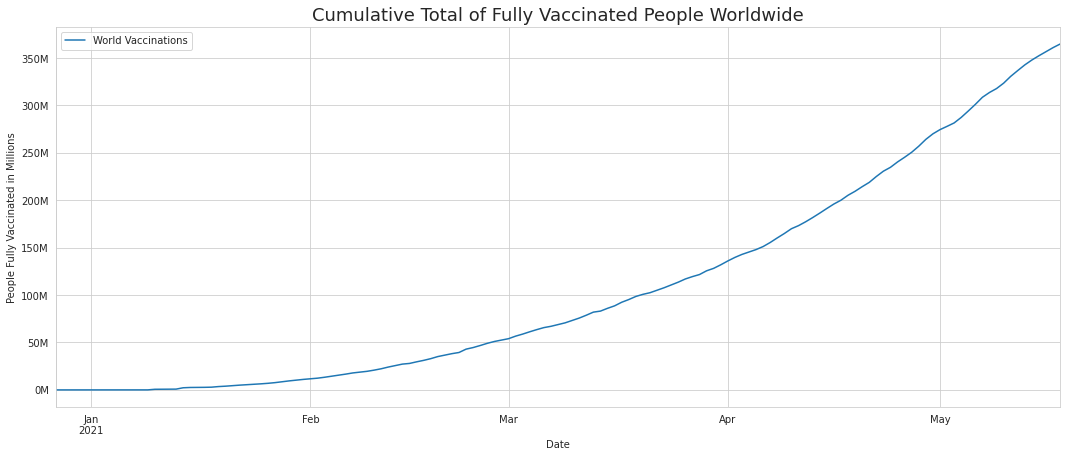

In [ ]:
# plot World vaccinations
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
world_df.plot(figsize= (18, 7), ax= ax)
plt.legend(['World Vaccinations'], fancybox= True)
plt.title('Cumulative Total of Fully Vaccinated People Worldwide', fontsize= 18)
plt.ylabel('People Fully Vaccinated in Millions')
plt.show()

From above graph we can conclude that:
1. Vaccination data has upward trend, It looks like exponential trend 
2. As more vaccines are approved day by day for use, so it is convering into exponential trend 


##Graph: Progress of vaccination worldwide

Text(0.5, 1.05, 'Progress of vaccination worldwide\n\n')

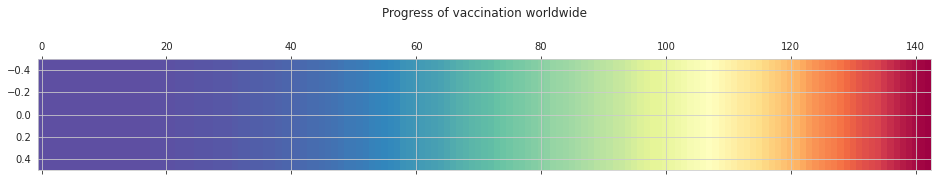

In [ ]:
plt.matshow(world_df.T, interpolation= None, aspect= 'auto', cmap = plt.cm.Spectral_r);
plt.title("Progress of vaccination worldwide\n\n")

From above graph we can conclude that as colors progress changes over the time, Hence there is increase in vaccination

#Pre-processing for ARIMA and LSTM Model

##Augmented Dickey Fuller test (ADF Test)

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. 

It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

1. In ARIMA time series forecasting, the first step is to determine the number of differencing required to make the series stationary.

2. Since testing the stationarity of a time series is a frequently performed activity in autoregressive models, the ADF test is something that you need to be fluent in when performing time series analysis.

3. Another point to remember is the ADF test is fundamentally a statistical significance test. 

4. That means, there is a hypothesis testing involved with a null and alternate hypothesis and as a result a test statistic is computed and p-values get reported.

5. It is from the test statistic and the p-value, you can make an inference as to whether a given series is stationary or not.







In [ ]:
# Create function to calculate Dickey Fuller test and plot rolling statistics
def stationarity_check(time_series_data):
    
    # Calculate rolling statistics
    roll_mean = time_series_data.rolling(window=8, center=False).mean()
    roll_std = time_series_data.rolling(window=8, center=False).std()
   
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(time_series_data, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xticks(rotation = 45) 
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform the Dickey Fuller test
    dftest = adfuller(time_series_data, autolag = "AIC")
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

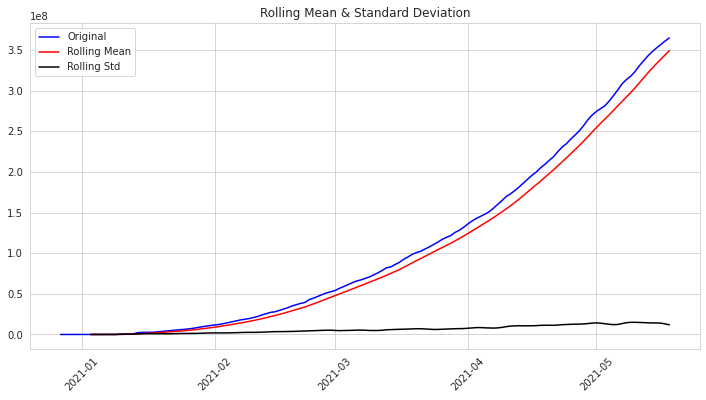

Results of Dickey-Fuller Test: 

Test Statistic                  -1.972057
p-value                          0.298958
#Lags Used                       7.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


In [ ]:
stationarity_check(world_df)

From above ADF test we can conclude:

1. The p-value is 0.998 which is very high. hence It is not a stationary time series.
2. We need to find out certain trend which can be helpful to make the series stationary



lets Log transform data and see is that helpful to remove the trend?

Text(0.5, 1.0, 'Log transform data\n')

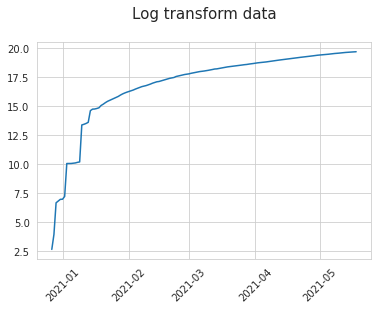

In [ ]:
# Log transform data and see if that removed trend?
ts_log = np.log(world_df)
plt.plot(ts_log)
plt.xticks(rotation = 45) 
plt.title("Log transform data\n",fontsize=15)

Subtract the exponential weighted rolling mean with a halflife of 2

Text(0.5, 1.0, 'Subtract the exponential weighted rolling mean with a halflife of 2\n')

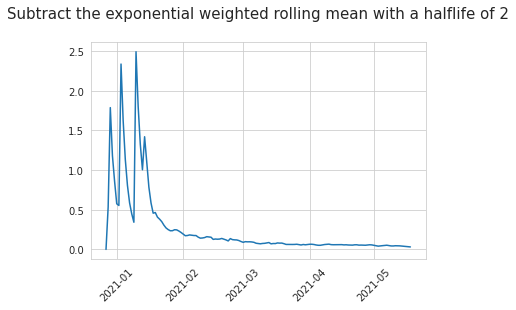

In [ ]:
# Subtract the exponential weighted rolling mean with a halflife of 2
exponential_roll_mean = ts_log.ewm(halflife= 2).mean()
minus_exp_roll_mean = ts_log - exponential_roll_mean
plt.xticks(rotation = 45) 
plt.plot(minus_exp_roll_mean)
plt.title("Subtract the exponential weighted rolling mean with a halflife of 2\n",fontsize=15)

Finally, use differencing to remove enough trend to get a low p-value

In [ ]:
# Finally, use differencing to remove enough trend to get a low p-value
differencing = minus_exp_roll_mean.diff(periods= 4)
differencing.dropna(inplace= True)

visualize data after differencing and check p-value with Dickey Fuller test

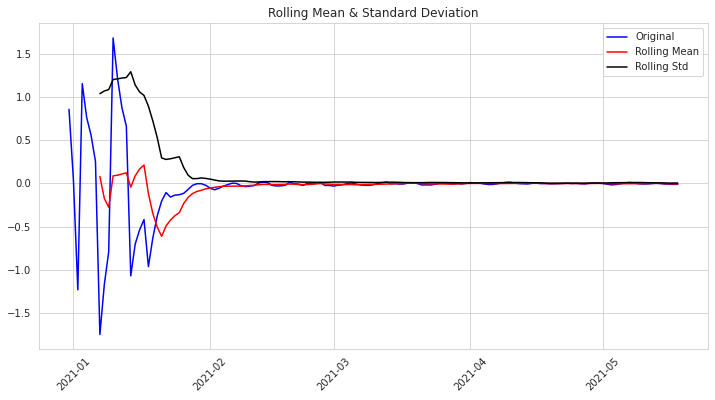

Results of Dickey-Fuller Test: 

Test Statistic                -1.105960e+01
p-value                        4.846813e-20
#Lags Used                     1.400000e+01
Number of Observations Used    1.240000e+02
Critical Value (1%)           -3.484220e+00
Critical Value (5%)           -2.885145e+00
Critical Value (10%)          -2.579359e+00
dtype: float64


In [ ]:
# visualize data after differencing and check p-value with Dickey Fuller test
stationarity_check(differencing)

**P-Value = 0.001**  -- This is a low enough p-value to consider any trends erased and we can now use this data to model and predict.

##Exploratoty Time Series Decomposition 

1. Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

2. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

3. Here will discover time series decomposition and how to automatically split a time series into its components with Python.

Now let's try decomposition and see if performs better than differencing.

In [ ]:
# calculate decomposition and separate the components
decomposition = seasonal_decompose(np.log(world_df), model= 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


###Plot original time series

Text(0.5, 1.0, 'Original Time Series\n')

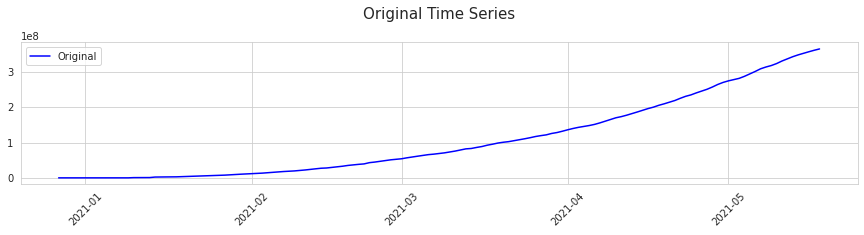

In [ ]:
# Plot statistics
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(world_df, label='Original', color='blue')
plt.xticks(rotation = 45) 
plt.legend(loc='best')
plt.title('Original Time Series\n',fontsize=15)

###Plot Trend in Time Series

Text(0.5, 1.0, 'Trend in Time Series\n')

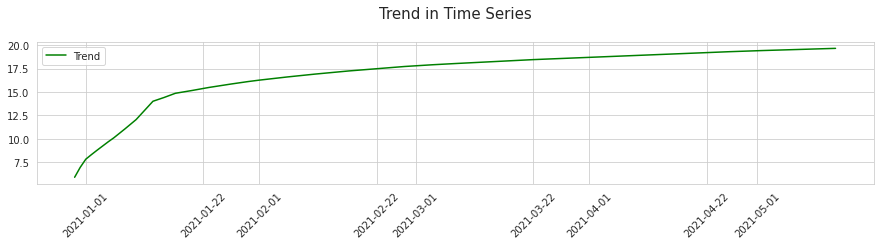

In [ ]:
# Plot statistics
plt.figure(figsize=(15,12))
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.xticks(rotation = 45) 
plt.legend(loc='best')
plt.title('Trend in Time Series\n',fontsize=15)

###Plot Seasonality in Time Series

Text(0.5, 1.0, 'Seasonality in Time Series\n')

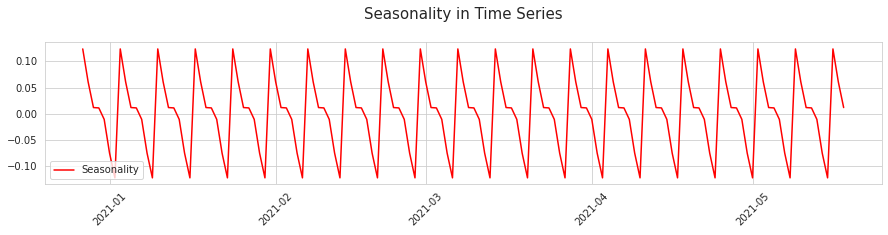

In [ ]:
# Plot statistics
plt.figure(figsize=(15,12))
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='red')
plt.xticks(rotation = 45) 
plt.legend(loc='best')
plt.title('Seasonality in Time Series\n',fontsize=15)

###Plot Residuals in Time Series

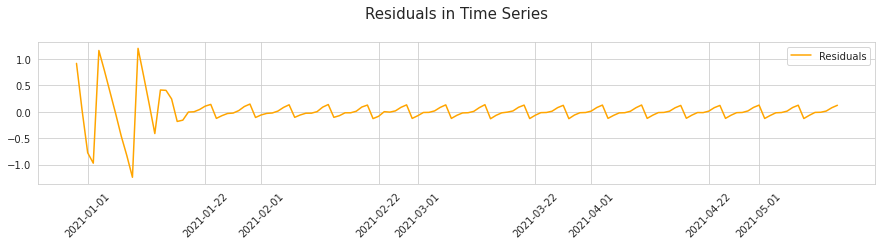

In [ ]:
# Plot statistics
plt.figure(figsize=(15,12))
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.xticks(rotation = 45) 
plt.title('Residuals in Time Series\n',fontsize=15)
plt.legend(loc='best')

Text(0.5, 1.0, 'Decomposed World Vaccination Data')

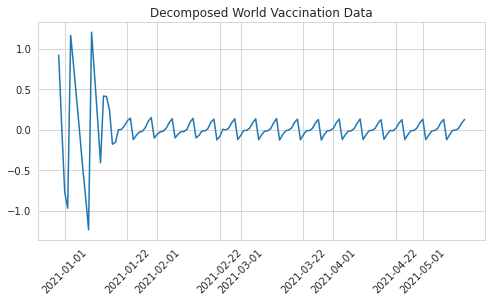

In [ ]:
# use only the residuals to build decomposed data
ts_log_decompose = residual
ts_log_decompose.dropna(inplace= True)

plt.figure(figsize= (8, 4))
plt.plot(ts_log_decompose)
plt.xticks(rotation = 45) 
plt.title('Decomposed World Vaccination Data')

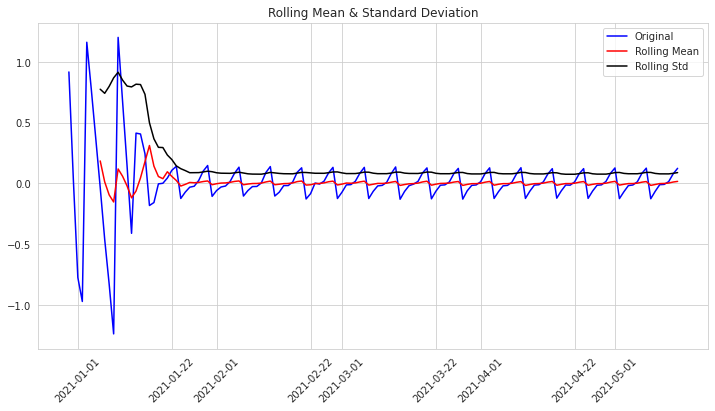

Results of Dickey-Fuller Test: 

Test Statistic                -8.280492e+00
p-value                        4.533604e-13
#Lags Used                     7.000000e+00
Number of Observations Used    1.290000e+02
Critical Value (1%)           -3.482088e+00
Critical Value (5%)           -2.884219e+00
Critical Value (10%)          -2.578864e+00
dtype: float64


In [ ]:
stationarity_check(ts_log_decompose)

This shows a **p-value of 0.00000** - can't get it any lower than that!

##Plot Auto-Correlation Function

Autocorrelation refers to how correlated a time series is with its past values whereas the ACF is the plot used to see the correlation between the points, up to and including the lag unit. 

In ACF, the correlation coefficient is in the x-axis whereas the number of lags is shown in the y-axis.

The Autocorrelation function plot will let you know how the given time series is correlated with itself

Normally in an ARIMA model, we make use of either the AR term or the MA term. We use both of these terms only on rare occasions. We use the ACF plot to decide which one of these terms we would use for our time series

1. If there is a Positive autocorrelation at lag 1 then we use the AR model
2. If there is a Negative autocorrelation at lag 1 then we use the MA model

Below is the autocorrelation plot to view all lags

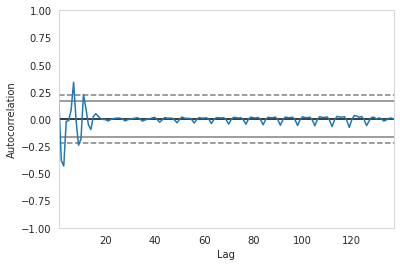

In [ ]:
# use pandas autocorrelation plot to view all lags
autocorrelation_plot(ts_log_decompose)
plt.show()

Below is the Auto-Correlation Function plot to view all lags

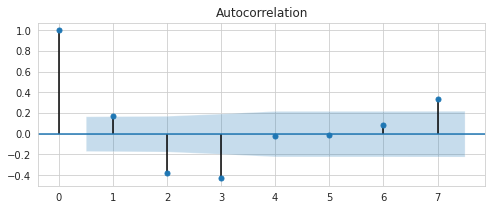

In [ ]:
# plot ACF 
fig, ax = plt.subplots(figsize= (8, 3))
plot_acf(ts_log_decompose, ax= ax, lags= 7);

##Plot Partial Auto-Correlation Function

After plotting the ACF plot we move to Partial Autocorrelation Function plots (PACF). 

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
1. If the PACF plot drops off at lag n, then use an AR(n) model 
2. if the drop in PACF is more gradual then we use the MA term

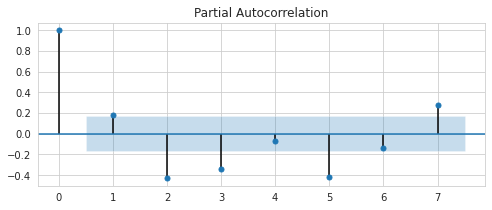

In [ ]:
#plot PACF
fig, ax = plt.subplots(figsize= (8, 3))
plot_pacf(ts_log_decompose, ax= ax, lags= 7);

From above we can conclude


1. Use AR terms in the model when the ACF plots show autocorrelation decaying towards zero
2. PACF plot cuts off quickly towards zero ACF of a stationary series shows positive at lag-1
3. Use MA terms in the model when the model is Negatively Autocorrelated at Lag — 1

ACF that drops sharply after a few lags PACF decreases more gradually


## Calculations of World Population

We need calculate the 70% of world population 

As per assumptions, people vaccinating are above the age of 16 years.

S0,lets calculate below :

1. World Population in 2021
2. Population over 16 years old
3. Herd Immunity : 70.0%
4. Population that needs to be vaccinated for herd immunity

In [ ]:
# calculate number of people that need to be vaccinated worldwide 
# to reach herd immunity

world_pop = 7874965825
print('World Population in 2021: {:,.0f}'.format(world_pop))

#26% of population under 16 yrs old
pop_percent_under_16 = .26
w_pop_over16 = world_pop * (1 - pop_percent_under_16)
print('Population over 16 years old: {:,.0f}'.format(w_pop_over16))

herd_immunity = .7
pop_need_fully_vax = w_pop_over16 * herd_immunity
print('Herd Immunity : {}%'.format(herd_immunity *100))
print('Population that needs to be vaccinated for herd immunity: {:,.0f}'\
      .format(pop_need_fully_vax) )

World Population in 2021: 7,874,965,825
Population over 16 years old: 5,827,474,710
Herd Immunity : 70.0%
Population that needs to be vaccinated for herd immunity: 4,079,232,297


We will try to build a model that can predict when almost 4.1 billion people will be vaccinated

In [ ]:
# create DataFrame to keep results from models
cols = ['model', 'RMSE', 'MAPE', '70p_herd_imm']
results_df = pd.DataFrame(columns= cols)

# Time Series Modeling

# Model-PMD  ARIMA

**ARIMA -ARIMA, short for 'Auto Regressive Integrated Moving Average'** 


**Autoregressive component:(AR)** A purely AR model forecasts only using a combination of the past values sorta like linear regression where the number of AR terms used is directly proportional to the number of previous periods taken into consideration for the forecasting.

**Moving Averages:(MA)** Random jumps in the time series plot whose effect is felt in two or more consecutive periods. These jumps represent the error calculated in our ARIMA model and represent what the MA component would lag for. A purely MA model would smooth out these sudden jumps like the exponential smoothing method.

**Integrated component:(I)** This component comes into action when the time series is not stationary. The number of times we have to difference the series to make it stationary is the parameter(i-term) for the integrated component
We can represent our model as ARIMA(ar-term, ma-term, i-term)

**ARIMA(p,d,q)(P, D, Q)m, is defined as**
<br>p — the number of autoregressive
<br>d — degree of differencing
<br>q — the number of moving average terms
<br>m — refers to the number of periods in each season
(P, D, Q )— represents the (p,d,q) for the seasonal part of the time series

Seasonal differencing takes into account the seasons and differences the current value and it’s value in the previous season eg: Difference for the month may would be value in May 2020 — value in may 2021.

1. In Purely seasonal AR model, ACF decays slowly while PACF cuts off to zero
2. AR models are used when seasonal auto-correlation is positive
3. In Purely seasonal MA model, ACF cuts off to zero and vice versa
4. MA models are used when seasonal auto-correlation is negative

**Final steps to perform ARIMA Model**

Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.

Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this

Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).

Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

##Perform Augmented Dickey Fuller test

In [ ]:
# check Augmented Dickey Fuller test
adf_test = ADFTest(alpha= 0.05)
adf_test.should_diff(world_df)

(0.99, True)

##Split The Data

In [ ]:
# a train/test split
train, test = train_test_split(world_df, test_size= 0.1)
print('Shape of train data ',train.shape)
print('Shape of test data ',test.shape)

Shape of train data  (128, 1)
Shape of test data  (15, 1)


##Plot Training and Testing Data

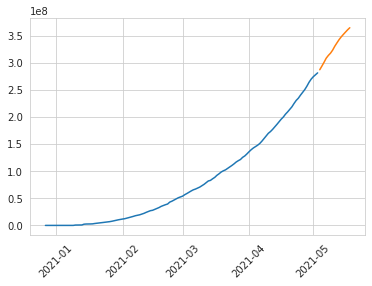

In [ ]:
# plot train and test
plt.plot(train)
plt.plot(test)
plt.xticks(rotation = 45) 
plt.show()

## Instantiate and fit ARIMA model using pmdarima library

In [ ]:
# CHANGED added stepwise= true, m= 7
# instantiate and fit model using pmdarima library
pmd_model = pm.auto_arima(train, stepwise= True, m= 7)
pmd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  128
Model:             SARIMAX(3, 2, 2)x(1, 0, [], 7)   Log Likelihood               -1846.146
Date:                            Thu, 20 May 2021   AIC                           3706.292
Time:                                    05:47:23   BIC                           3726.146
Sample:                                         0   HQIC                          3714.358
                                            - 128                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1673      0.129      9.023      0.000       0.914       1.421
ar.L2         -0.1446      0.160     -0.903      0.367      -0.458       0.169
ar.L3         -0.2117      0.122     -1.733      0.083      -0.451       0.028
ma.L1         -1.8534      0.082    -22.510      0.000      -2.015      -1.692
ma.L2          0.9003      0.076     11.883      0.000       0.752       1.049
ar.S.L7        0.4848      0.102      4.768      0.000       0.286       0.684
sigma2      3.474e+11   8.52e-14   4.08e+24      0.000    3.47e+11    3.47e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                16.79
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               6.44   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.52e+40. Standard errors may be unstable.
"""

##Calculate Root Mean Square Error (RMSE) 

In [ ]:
# calculate RMSE
preds, conf_int = pmd_model.predict(n_periods=test.shape[0], return_conf_int=True)
pmd_rmse = mean_squared_error(test, preds, squared= False)
print('PMD RMSE: {:,.2f}'.format(pmd_rmse))

PMD RMSE: 6,418,493.80


##Calculate Mean Absolute Percentage Error (MAPE)

In [ ]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
pmd_mape = round(np.mean(np.abs((test.values - preds)/test.values))* 100, 3)  
print('PMD MAPE: {}'.format(pmd_mape))

PMD MAPE: 8.248


## Plot test and predicted data

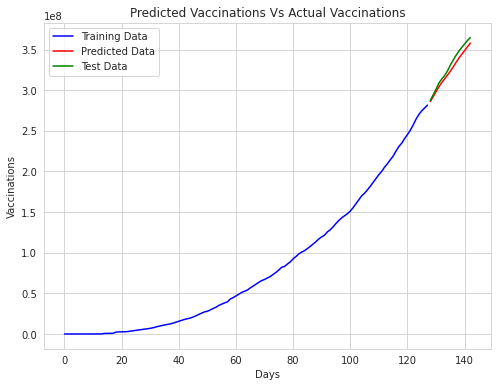

In [ ]:
# plot test and predicted data
x = np.arange(world_df.shape[0])
n = train.shape[0]

plt.figure(figsize= (8, 6))
plt.plot(x[:n], train, c='blue', label= 'Training Data')
plt.plot(x[n:], preds, c='red', label= 'Predicted Data')
plt.plot(x[n:], test, c= 'green', label= 'Test Data')
plt.title('Predicted Vaccinations Vs Actual Vaccinations')
plt.xlabel('Days')
plt.ylabel('Vaccinations')
plt.legend()
plt.show()

##Forecasting with ARIMA model

Prediction for next 21 days

In [ ]:
# predict next 21 days
next_n = pmd_model.predict(n_periods= 21)

Function to plot ARIMA data 

In [ ]:
# function to plot data
def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth_idx = np.arange(truth.shape[0])
    truths = truth.loc[:, 'people_fully_vaccinated']
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth_idx, truths.values, legend_label='Observed', 
           line_width= 3, line_color = '#0099ff')
    p.line(forecasts.index, forecasts.values, legend_label='Forecasted', 
           line_width= 3, line_color= '#ff9933')
    
    p.yaxis[0].formatter = NumeralTickFormatter(format= '0.0a')
    p.legend.location = 'bottom_right'
    
    return p

In [ ]:
# show plot
show(plot_arima(world_df, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

###.

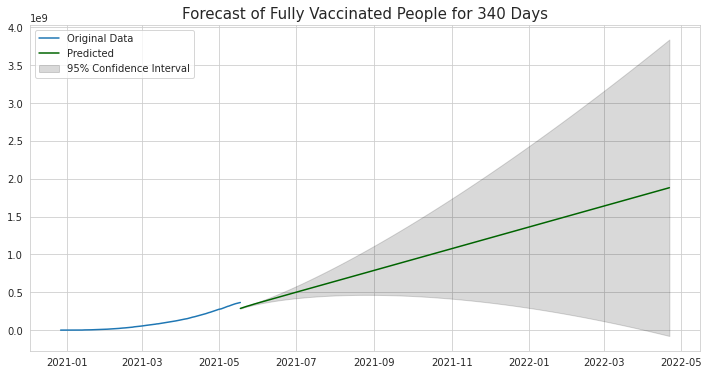

In [ ]:
# plot using matplotlib and showing confidence interval
n_periods = 340
fitted, confint = pmd_model.predict(n_periods= n_periods, return_conf_int= True)
index_of_fc = pd.date_range(world_df.index[-1], periods= n_periods, freq= 'd')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#plot figure
plt.figure(figsize= (12, 6))
plt.plot(world_df, label= 'Original Data')
plt.plot(fitted_series, color= 'darkgreen', label= 'Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color= 'k', 
                 alpha= 0.15, label= '95% Confidence Interval')
plt.title('Forecast of Fully Vaccinated People for 340 Days',fontsize=15)
plt.legend(loc= 'upper left')
plt.show()

Predict for 1475 days into the future

In [ ]:
# predict for 1475 days into the future
next_n = pmd_model.predict(n_periods= 1475)

# plot
show(plot_arima(world_df, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

## Calculate Herd Immunity in years

In [ ]:
# calculate that into years
pmd_imm = (340 + len(world_df)) / 365
print('# of years until reaching herd immunity:', round(pmd_imm, 1))

# of years until reaching herd immunity: 1.3


In [ ]:
pmd_imm = datetime.date(2022, 5, 1)

In [ ]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['PMD ARIMA', pmd_rmse, pmd_mape, pmd_imm]

#Model Statsmodels ARIMA

An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

##Model Summary

Use ARIMA from statsmodels to predict future vaccinations

In [ ]:
# use ARIMA from statsmodels to predict future vaccinations
sm_model = ARIMA(train, order= (0, 2, 1))
fitted = sm_model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                  126
Model:                         ARIMA(0, 2, 1)   Log Likelihood               -1861.493
Method:                               css-mle   S.D. of innovations         627274.530
Date:                        Thu, 20 May 2021   AIC                           3728.987
Time:                                05:47:25   BIC                           3737.496
Sample:                            12-29-2020   HQIC                          3732.444
                                 - 05-03-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             4.184e+04   7896.684      5.299      0.000    2.64e+04    5.73e+04
ma.L1.D2.people_fully_vaccinated    -0.8723      0.057    -15.356      0.000      -0.984      -0.761
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1464           +0.0000j            1.1464            0.0000
-----------------------------------------------------------------------------
"""

Get forecast, standard error and confidence interval

In [ ]:
# get forecast, standard error and confidence interval
fc, se, conf = fitted.forecast(test.shape[0], alpha= 0.05)

In [ ]:
print(fitted.forecast())

(array([2.86737715e+08]), array([627274.52960335]), array([[2.85508279e+08, 2.87967150e+08]]))


##Create Series to Plot Data

In [ ]:
# create series to plot data
fc_series = pd.Series(fc, index= test.index)
lower_series = pd.Series(conf[:, 0], index= test.index)
upper_series = pd.Series(conf[:, 1], index= test.index)


##Plot Actual Data vs Predicted 

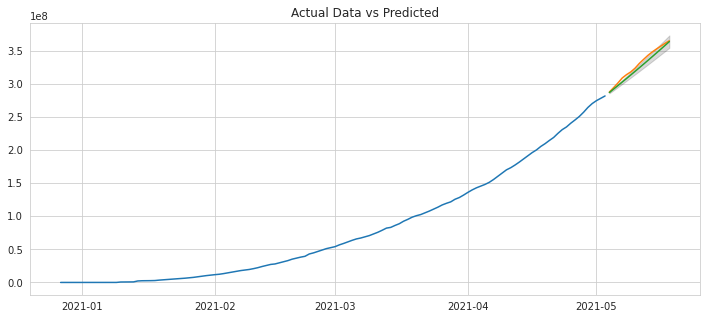

In [ ]:
# plot
plt.figure(figsize= (12, 5))
plt.plot(train, label= 'training')
plt.plot(test, label= 'test')
plt.plot(fc_series, label= 'forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color= 'k',  alpha= 0.15)
plt.title('Actual Data vs Predicted')
plt.show()

##Calculate Root Mean Squared Error(RMSE)

In [ ]:
# calculate root mean squared error
sm_rmse = mean_squared_error(test.values, fc, squared= False)
print('RMSE: {:,.2f}'.format(sm_rmse))

RMSE: 5,201,474.06


##Calculate Mean Absolute Percentage Error (MAPE)

In [ ]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
sm_mape = round(np.mean(np.abs((test.values - fc)/test.values))*100, 3)  
print('MAPE:', sm_mape)

MAPE: 8.507


This model is about 92% accurate in predicting the next 8 days and predictions are about 933,000 people off. Not too bad when we are looking at 100's of millions of people.

## Build ARIMA model with whole dataset

In [ ]:
# build and fit ARIMA model with whole dataset
# use p, d, q from auto_arima
model = ARIMA(world_df, order= (0, 2, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                  141
Model:                         ARIMA(0, 2, 1)   Log Likelihood               -2103.177
Method:                               css-mle   S.D. of innovations         724764.193
Date:                        Thu, 20 May 2021   AIC                           4212.354
Time:                                05:47:26   BIC                           4221.200
Sample:                            12-29-2020   HQIC                          4215.949
                                 - 05-18-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.242e+04    1.4e+04      2.313      0.021    4949.643    5.99e+04
ma.L1.D2.people_fully_vaccinated    -0.7990      0.086     -9.326      0.000      -0.967      -0.631
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2515           +0.0000j            1.2515            0.0000
-----------------------------------------------------------------------------
"""

##Plot Test and Predicted data

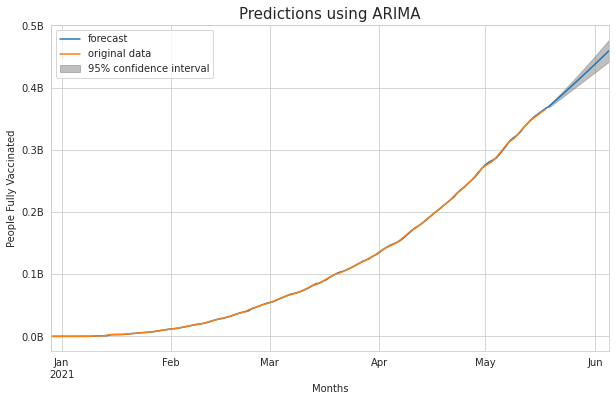

In [ ]:
# Change format of y labels to billions
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(2, 160, ax= ax)

plt.title('Predictions using ARIMA',fontsize=15)
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])
plt.show()

###.

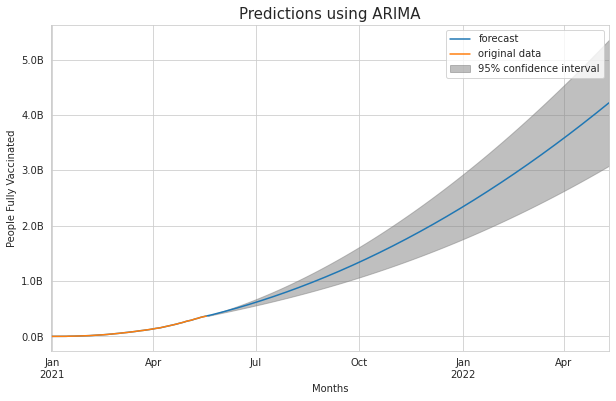

In [ ]:
# Change format of y labels to billions
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(4, 500, ax= ax)

plt.title('Predictions using ARIMA',fontsize=15)
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])
plt.show()

## Calculate Estimated Immunity

In [ ]:
# calculate estimated immunity
sm_imm = (485 - len(world_df)) 
sm_imm = datetime.date(2022, 4, 1)

In [ ]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['SM ARIMA', sm_rmse, sm_mape, sm_imm]

#Model ARIMA Grid Search and SARIMAX

In [ ]:
def arima_grid_search():
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 4)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(world_df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# takes approx 40 minutes to run
# arima_grid_search()

Uncomment the cell above to run or save time and view the results from this image.



## Hyperparameters from Grid search

In [ ]:
mod_train = sm.tsa.statespace.SARIMAX(train, order=(0,2,1), 
                                seasonal_order=(0,2,2,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax_results = mod_train.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                people_fully_vaccinated   No. Observations:                  128
Model:             SARIMAX(0, 2, 1)x(0, 2, [1, 2], 7)   Log Likelihood               -1436.765
Date:                                Thu, 20 May 2021   AIC                           2881.531
Time:                                        05:47:27   BIC                           2891.788
Sample:                                    12-27-2020   HQIC                          2885.677
                                         - 05-03-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8463      0.221     -3.822      0.000      -1.280      -0.412
ma.S.L7       -1.7406      0.192     -9.062      0.000      -2.117      -1.364
ma.S.L14       0.7482      0.190      3.937      0.000       0.376       1.121
sigma2      1.137e+12   5.96e-14   1.91e+25      0.000    1.14e+12    1.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.78
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               3.45   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+41. Standard errors may be unstable.
"""

##Get forecast, standard error and confidence interval

In [ ]:
# get forecast, standard error and confidence interval
frcst= sarimax_results.forecast(test.shape[0])

In [ ]:
frcst.values

array([2.86797406e+08, 2.92593855e+08, 2.99045221e+08, 3.05022848e+08,
       3.10089103e+08, 3.14957679e+08, 3.19909300e+08, 3.25519943e+08,
       3.31701180e+08, 3.38554039e+08, 3.44919191e+08, 3.50349558e+08,
       3.55579433e+08, 3.60892979e+08, 3.66881469e+08])

##Calculate Root Mean Squared Error (RMSE)

In [ ]:
# calculate root mean squared error
smx_rmse = mean_squared_error(test.values, frcst, squared= False)
print('RMSE: {:,.2f}'.format(smx_rmse))

RMSE: 3,113,219.65


##Calculate Mean Absolute Percentage Error (MAPE)

In [ ]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
smx_mape = round(np.mean(np.abs((test.values - frcst.values)/test.values))*100, 3)  
print('MAPE:', smx_mape)

MAPE: 8.638


##Calculate Estimated Herd Immunity

Now, we'll run the model on whole dataset and get the herd immunity estimate.

In [ ]:
mod = sm.tsa.statespace.SARIMAX(world_df, order=(0,2,1), 
                                seasonal_order=(0,2,2,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax_results = mod.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                people_fully_vaccinated   No. Observations:                  143
Model:             SARIMAX(0, 2, 1)x(0, 2, [1, 2], 7)   Log Likelihood               -1675.746
Date:                                Thu, 20 May 2021   AIC                           3359.491
Time:                                        05:47:28   BIC                           3370.329
Sample:                                    12-27-2020   HQIC                          3363.888
                                         - 05-18-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7490      0.182     -4.123      0.000      -1.105      -0.393
ma.S.L7       -1.8438      0.198     -9.326      0.000      -2.231      -1.456
ma.S.L14       0.8589      0.209      4.104      0.000       0.449       1.269
sigma2      1.496e+12    2.4e-14   6.24e+25      0.000     1.5e+12     1.5e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.58   Prob(JB):                         0.72
Heteroskedasticity (H):               4.71   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+41. Standard errors may be unstable.
"""

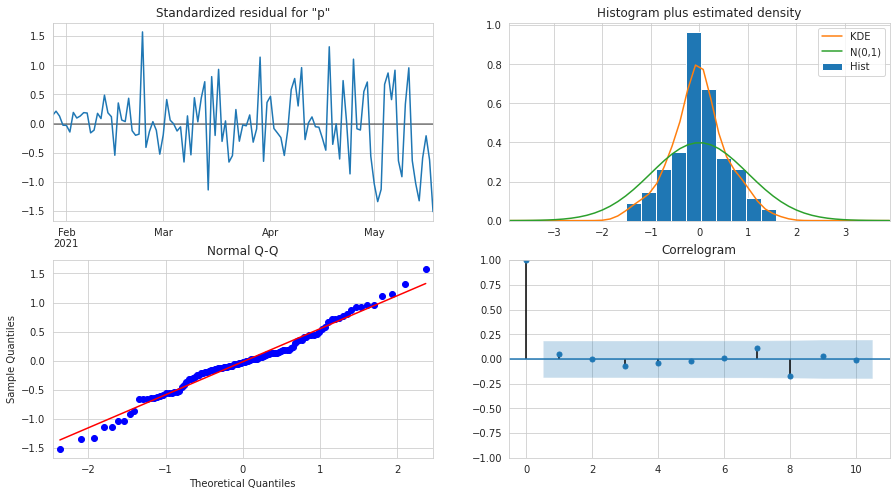

In [ ]:
sarimax_results.plot_diagnostics(figsize= (15,8))
plt.show()

##SARIMAX Forecast

In [ ]:
# function to get forecast and plot 
def get_forecast(steps):
    # Get forecast 500 steps ahead in future
    prediction = sarimax_results.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
#     Plot future predictions with confidence intervals
    formatter = FuncFormatter(billions)
    ax = world_df.plot(figsize= (15, 8))
    prediction.predicted_mean.plot(ax= ax)
    ax.yaxis.set_major_formatter(formatter)
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Month')
    ax.set_ylabel('People Fully Vaccinated')
    plt.title('SARIMAX Forecast', fontsize = 16)

    plt.legend(labels= ['original data ', 'forecast', '95% confidence interval'], 
               loc= 'upper left')
    plt.show()

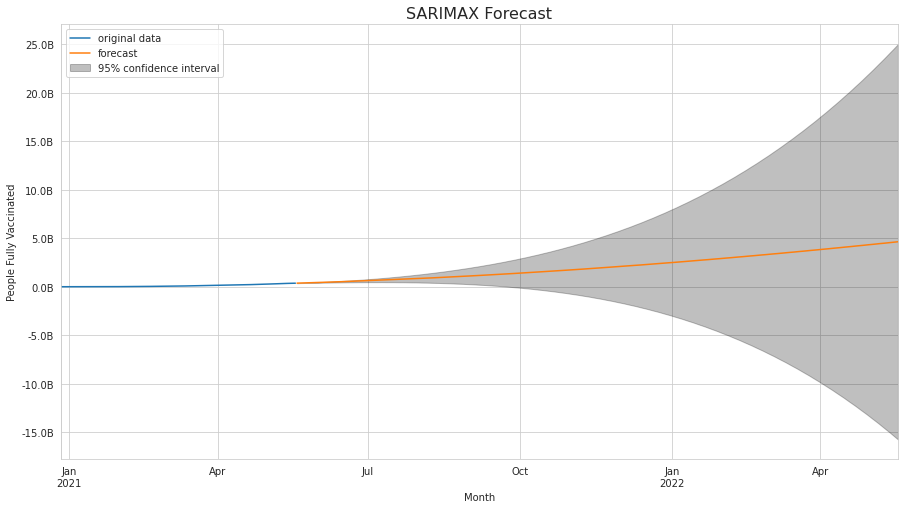

In [ ]:
get_forecast(365)

In [ ]:
smx_imm = datetime.date(2022, 3, 1)

In [ ]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['SM SARIMAX', smx_rmse, smx_mape, smx_imm]

SARIMAX predicts around March 2022

#Exponential Smoothing

**Exponential Smoothing:**
1. The Exponential Smoothing (ES) technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value. 
2. When you use ES, you are making the crucial assumption that recent values of the time series are much more important to you than older values. The ES technique has two big shortcomings: It cannot be used when your data exhibits a trend and/or seasonal variations.

**Holt Exponential Smoothing:**
1. The Holt ES technique fixes one of the two shortcomings of the simple ES technique. 
2. Holt ES can be used to forecast time series data that has a trend. But Holt ES fails in the presence of seasonal variations in the time series.

##Exponential Moving Average 

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly.




In [ ]:
world = world_df.copy()

In [ ]:
# get exponential weighted moving average using pandas
world['EWM'] = world['people_fully_vaccinated'].ewm(span= 3).mean()
world

,people_fully_vaccinated,EWM
Date,,
2020-12-27,14.0,1.400000e+01
2020-12-28,51.0,3.866667e+01
2020-12-29,785.0,4.651429e+02
2020-12-30,911.0,7.029333e+02
2020-12-31,1060.0,8.872258e+02
...,...,...
2021-05-14,347962966.0,3.423443e+08
2021-05-15,352491153.0,3.474177e+08
2021-05-16,356814607.0,3.521162e+08


##Exponential Weighted Moving Average Prediction

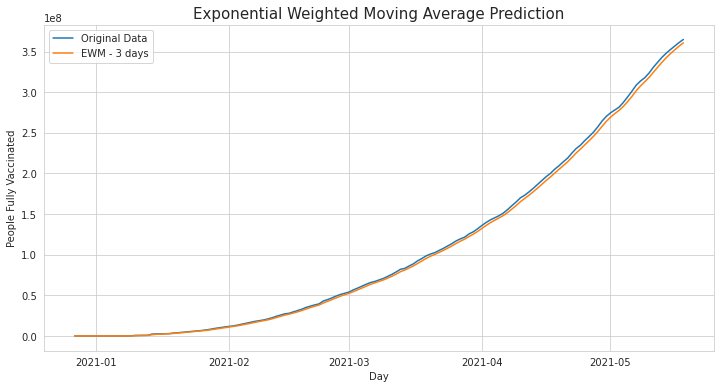

In [ ]:
plt.figure(figsize= (12, 6))
plt.plot(world['people_fully_vaccinated'], label = 'Original Data')
plt.plot(world['EWM'], label= 'EWM - 3 days')
plt.title('Exponential Weighted Moving Average Prediction', fontsize= 15)
plt.xlabel('Day')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()

##Calculate Root Mean Squared Error (RMSE)

In [ ]:
ewm_rmse = mean_squared_error(world['people_fully_vaccinated'], world['EWM'], squared= False)
print('EWM RMSE: {:,.2f}'.format(ewm_rmse))

EWM RMSE: 3,172,304.15


## Holt Exponential Smoothing

Because the model does not have any seasonality (there barely has even been one season within this data) but does have an upward trend.

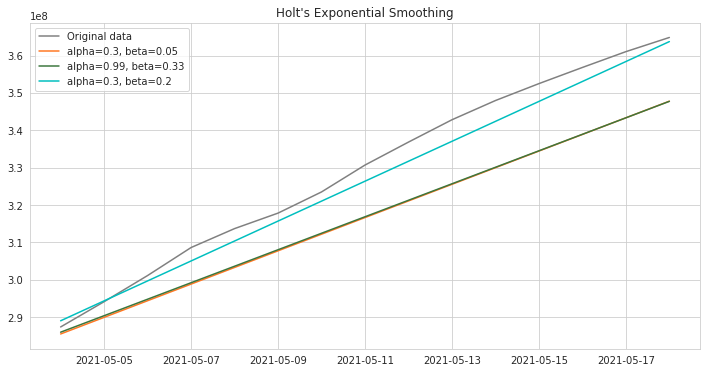

In [ ]:
model = Holt(np.asarray(train['people_fully_vaccinated']))
model.index = train.index

n= len(test.values)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(n)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(n)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(n)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray", label= 'Original data')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color= 'r')
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

##Model Summary

In [ ]:
# set freq to days
world_df.index.freq = 'D'

In [ ]:
# fit Holt model and get summary
holt_model = Holt(train, exponential= True)
fitted = holt_model.fit()
fitted.summary()

Dep. Variable:,people_fully_vaccinated,No. Observations:,128
Model:,Holt,SSE,139293017809386.656
Optimized:,True,AIC,3555.593
Trend:,Multiplicative,BIC,3567.001
Seasonal:,None,AICC,3556.287
Seasonal Periods:,None,Date:,"Thu, 20 May 2021"
Box-Cox:,False,Time:,05:47:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3114286,alpha,True
smoothing_trend,0.2978882,beta,True


In [ ]:
# n steps = length of test group
vax_forecast = fitted.forecast(steps= n)

##Plot Training and Testing Data

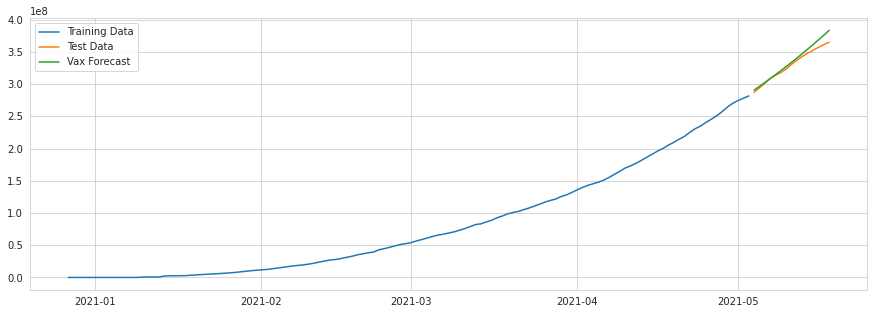

In [ ]:
# plot
fig, ax = plt.subplots(figsize= (15,5))
plt.plot(train.index, train, label= 'Training Data')
plt.plot(test.index, test, label= 'Test Data')
plt.plot(test.index, vax_forecast, label= 'Vax Forecast')
plt.legend()
plt.show()

##Calculate Root Mean Squared Error (RMSE)

In [ ]:
# get RMSE for Holt model
holt_rmse = mean_squared_error(test, vax_forecast, squared= False)
print('Holt RMSE: {:,.2f}'.format(holt_rmse))

Holt RMSE: 7,690,202.04


##Forecast for N days

Predict 90 days ahead

In [ ]:
# forecast out n days
vax_far_forecast = fitted.forecast(steps= 90)

In [ ]:
#predict 90 days ahead
n_input= len(train.values)

add_dates = [world_df.index[-1] + DateOffset(days= x) for x in range(0, 90)]
future_dates = pd.DataFrame(index= add_dates[1:], columns= world_df.columns)

df_predict = pd.DataFrame(vax_far_forecast, index= future_dates[-n_input:].index, 
columns= ['Holt Prediction'])
df_proj = pd.concat([world_df, df_predict], axis= 1)

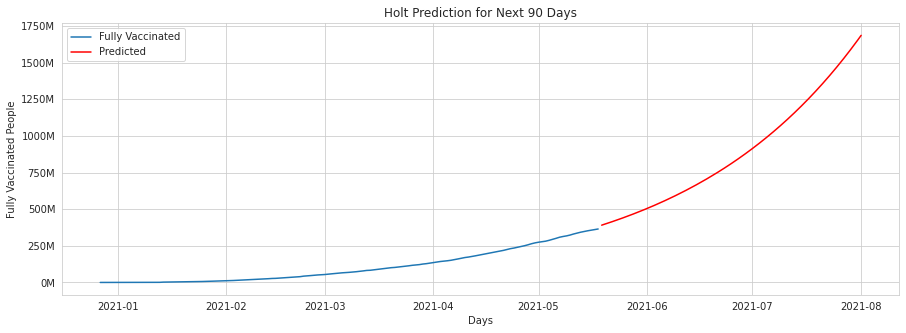

In [ ]:
# Change format of y labels to billions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize= (15,5))
ax.yaxis.set_major_formatter(formatter)
plt.plot(df_proj.index, df_proj['people_fully_vaccinated'])
plt.plot(df_proj.index, df_proj['Holt Prediction'], color= 'r')
plt.title('Holt Prediction for Next 90 Days')
plt.xlabel('Days')
plt.ylabel('Fully Vaccinated People')
plt.legend(labels= ['Fully Vaccinated', 'Predicted'])
plt.show()

The Holt Model predicts the World will hit 1 billion fully vaccinated people before July 2021.

Unfortunately, the model was not able to predict more than 90 days ahead.

#Model- Long Short Term Memory networks (LSTM)

1. What is LSTM?
<br>    It is a special kind of recurrent neural network that is capable of learning long term dependencies in data. 
<br>    This is achieved because the recurring module of the model has a combination of four layers interacting with each other.
2. Steps to perform LSTM
<br>Define Network.
<br>Compile Network.
<br>Fit Network.
<br>Evaluate Network.
<br>Make Predictions.


### Prepare Data

Set X values and reshape to use in LSTM

In [ ]:
# set X values and reshape to use in LSTM
X = world_df.values
X = X.reshape((-1,1))

###Split The Data

In [ ]:
# split for train / test
split_percent = 1-0.9
split = len(X) - 11 

X_train = X[:split]
X_test = X[split:]

date_train = world_df.index[:split]
date_test = world_df.index[split:]


##Time series generator

Use Time Series Generator and set look back to 3 days

In [ ]:
# use Time series generator and set look back to 3 days
look_back = 3
train_gen = TimeseriesGenerator(X_train, X_train, length= look_back, batch_size= 1)
test_gen = TimeseriesGenerator(X_test, X_test, length= look_back, batch_size= 1)
print(train_gen)
print(test_gen)

##Set Layers

Set layers for LSTM Sequential model

In [ ]:
# set layers for LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, activation= 'relu', input_shape= (look_back, 1), 
                    return_sequences= True))
lstm_model.add(LSTM(64, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(256, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
# lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(64, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(32, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(1, activation= 'relu'))

lstm_model.compile(optimizer= 'Adam', loss= 'mse')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 32)             4352      
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 64)             24832     
_________________________________________________________________
lstm_18 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
lstm_19 (LSTM)               (None, 3, 256)            394240    
_________________________________________________________________
lstm_20 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
lstm_21 (LSTM)               (None, 3, 64)             49408     
_________________________________________________________________
lstm_22 (LSTM)               (None, 3, 32)            

In [ ]:
lstm_model.fit(train_gen, epochs= 25)

Epoch 1/25
129/129 [==============================] - 12s 21ms/step - loss: 15324117230932158.0000
Epoch 2/25
129/129 [==============================] - 3s 21ms/step - loss: 992114178890137.6250
Epoch 3/25
129/129 [==============================] - 3s 21ms/step - loss: 151504526591258.5938
Epoch 4/25
129/129 [==============================] - 3s 21ms/step - loss: 1765760944961567.5000
Epoch 5/25
129/129 [==============================] - 3s 21ms/step - loss: 17512698157542804.0000
Epoch 6/25
129/129 [==============================] - 3s 21ms/step - loss: 9063286901234830.0000
Epoch 7/25
129/129 [==============================] - 3s 21ms/step - loss: 14598042480693438.0000
Epoch 8/25
129/129 [==============================] - 3s 22ms/step - loss: 5849648163914736.0000
Epoch 9/25
129/129 [==============================] - 3s 21ms/step - loss: 81675974131255.1406
Epoch 10/25
129/129 [==============================] - 3s 21ms/step - loss: 508002223533890.9375
Epoch 11/25
129/129 [=========

In [ ]:
prediction = lstm_model.predict(test_gen)
print(prediction.shape)

(8, 1)


##Plot LSTM data

In [ ]:
# plot data
# reshape to plot
X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
prediction = prediction.reshape((-1))

# plot using plotly
trace1 = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = 'LSTM Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'People Fully Vaccinated'}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

##Calculate Root Mean Squared Error (RMSE)

In [ ]:
# calculate RMSE
X_test = X_test[:8]

lstm_rmse = mean_squared_error(X_test, prediction, squared= False)
print('RMSE: {:,.2f}'.format(lstm_rmse))

RMSE: 15,447,139.27


##Calculate Mean Absolute Percentage Error (MAPE)

In [ ]:
# calculate MAPE (mean absolute percentage error)
# measure of prediction accuracy of a forecasting method in statistics
lstm_mape = round(np.mean(np.abs((X_test - prediction)/X_test))*100, 3)  
print('MAPE:', lstm_mape)

MAPE: 4.635


## Forecasting with LSTM

In [ ]:
# functions to forecast model
X = X.reshape((-1))

# predict future values (fully vaccinated people)
def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# create future dates for x-axis    
def predict_dates(num_prediction):
    last_date = world_df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

# num_prediction = number of days into future
num_prediction = 200
forecast = predict(num_prediction, lstm_model)
forecast_dates = predict_dates(num_prediction)

##Calculate Estimated Immunity

In [ ]:
# plot data
trace1 = go.Scatter(
    x = world_df.index,
    y = X,
    mode = 'lines',
    name = 'Original Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecasted Data'
)
layout = go.Layout(
    title = 'LSTM Forecast',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'People Fully Vaccinated'}
)

fig = go.Figure(data=[trace1, trace2], layout=layout,)
fig.show()

In [ ]:
# herd immunity date
lstm_imm = datetime.date(2021, 8, 15)

In [ ]:
# add to df
results_df.loc[len(results_df.index)] = ['LSTM', lstm_rmse, lstm_mape, lstm_imm]

#Combine Results of all models

In [ ]:
results_df

,model,RMSE,MAPE,70p_herd_imm
0,PMD ARIMA,6.418494e+06,8.248,2022-05-01
1,SM ARIMA,5.201474e+06,8.507,2022-04-01
2,SM SARIMAX,3.113220e+06,8.638,2022-03-01
3,LSTM,1.544714e+07,4.635,2021-08-15


##Plot MAPE and RMSE

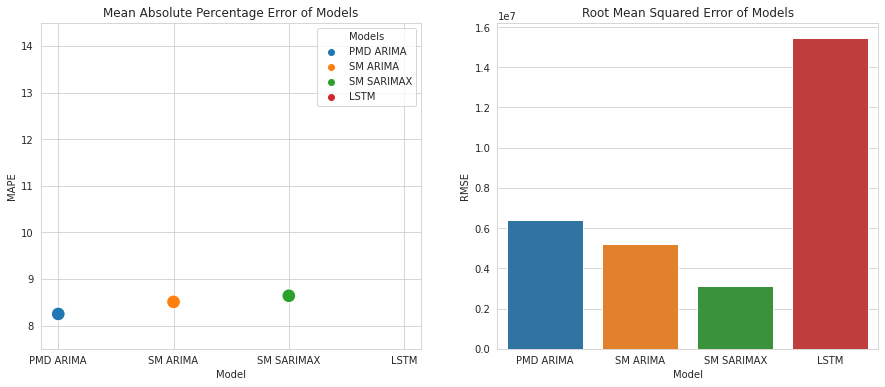

In [ ]:
fig = plt.figure(figsize= (15, 6))
ax = fig.add_subplot(121)
sns.scatterplot('model', 'MAPE', data = results_df, ax= ax, hue= 'model', s= 190)
ax.set_title('Mean Absolute Percentage Error of Models')
ax.set_xlabel('Model')
ax.legend(title= 'Models',loc='left')
ax.set_ylim(7.5, 14.5)


ax1 = fig.add_subplot(122)
sns.barplot('model', 'RMSE', data = results_df, ax= ax1)
ax1.set_title('Root Mean Squared Error of Models')
ax1.set_xlabel('Model');

In [ ]:
# set date as index to plot
results_df.set_index('70p_herd_imm', inplace= True)

##Plot Predicted Dates for Each Model

In [ ]:
# plot predicted dates
fig = px.scatter(results_df, 
                 x= results_df.index, 
                 y= 'model', 
                 color= 'model')

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title= 'Predicted 70% Herd Immunity Dates', 
    xaxis_title= '70% Herd Immunity Prediction Date', 
    yaxis_title = 'Model')

fig.show()

#Conclusion

1. All three of the ARIMA models were similar when looking at mean absolute percentage error, while statsmodels model was slightly higher.

2. Looking at those points, the two statsmodels models were able to get closer to the actual data (lower RMSE).

3. When looking at the RMSE and MAPE, either of the ARIMA models would be a reasonable choice. rather than LSTM model

4. When you look at the forecasted herd immunity, it appears that the statsmodels models might potentially be more accurate.

5. It seems more likely that it would take approximately a year, rather than a few months or 4 years.

6. In future we will know which one of these models is accurate.


#Future Steps

1. In LSTM model RMSE and MAPE values are very high, We need to work on the tuning of this model.
2. There are different types of LTSM model like Stacked,Bidirectional, Multivariate CNN to reach the minimum RMSE and MAPE value